In [1]:
import pandas as pd
import numpy as np
import shutil
import multiprocessing
from datetime import datetime

import tensorflow as tf
from tensorflow.python.feature_column import feature_column
from tensorflow.contrib.learn import learn_runner
from tensorflow.contrib.learn import make_export_strategy
from tensorflow import data

print(tf.__version__)

/Users/khalidsalama/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.4.0


In [2]:
MODEL_NAME = 'auto-encoder-01'

TRAIN_DATA_FILES_PATTERN = 'data/data-*.csv'

RESUME_TRAINING = False
MULTI_THREADING = False


## 1. Define Dataset Metadata

In [3]:
FEATURE_COUNT = 64

HEADER = ['key']
HEADER_DEFAULTS = [[0]]
UNUSED_FEATURE_NAMES = ['key']
CLASS_FEATURE_NAME = 'CLASS'
FEATURE_NAMES = []  

for i in range(FEATURE_COUNT):
    HEADER += ['x_{}'.format(str(i+1))]
    FEATURE_NAMES += ['x_{}'.format(str(i+1))]
    HEADER_DEFAULTS += [[0.0]]

HEADER += [CLASS_FEATURE_NAME]
HEADER_DEFAULTS += [['NA']]

print("Header: {}".format(HEADER))
print("Features: {}".format(FEATURE_NAMES))
print("Class Feature: {}".format(CLASS_FEATURE_NAME))
print("Unused Features: {}".format(UNUSED_FEATURE_NAMES))

Header: ['key', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64', 'CLASS']
Features: ['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59'

## 2. Define CSV Data Input Function

In [4]:
def parse_csv_row(csv_row):
    
    columns = tf.decode_csv(csv_row, record_defaults=HEADER_DEFAULTS)
    features = dict(zip(HEADER, columns))
    
    for column in UNUSED_FEATURE_NAMES:
        features.pop(column)

    target = features.pop(CLASS_FEATURE_NAME)

    return features, target

In [5]:
def csv_input_fn(files_name_pattern, mode=tf.estimator.ModeKeys.EVAL, 
                 skip_header_lines=0, 
                 num_epochs=None, 
                 batch_size=200):
    
    shuffle = True if mode == tf.estimator.ModeKeys.TRAIN else False
    
    print("")
    print("* data input_fn:")
    print("================")
    print("Input file(s): {}".format(files_name_pattern))
    print("Batch size: {}".format(batch_size))
    print("Epoch Count: {}".format(num_epochs))
    print("Mode: {}".format(mode))
    print("Shuffle: {}".format(shuffle))
    print("================")
    print("")
    
    file_names = tf.matching_files(files_name_pattern)

    dataset = data.TextLineDataset(filenames=file_names)
    dataset = dataset.skip(skip_header_lines)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)

    #useful for distributed training when training on 1 data file, so it can be shareded
    #dataset = dataset.shard(num_workers, worker_index)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda csv_row: parse_csv_row(csv_row))
    
    dataset = dataset.repeat(num_epochs)
    iterator = dataset.make_one_shot_iterator()
    
    features, target = iterator.get_next()

    return features, target

In [6]:
features, target = csv_input_fn(files_name_pattern="")
print("Feature read from CSV: {}".format(list(features.keys())))
print("Target read from CSV: {}".format(target))


* data input_fn:
Input file(s): 
Batch size: 200
Epoch Count: None
Mode: eval
Shuffle: False

Feature read from CSV: ['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64']
Target read from CSV: Tensor("IteratorGetNext:64", shape=(?,), dtype=string)


## 3. Define Feature Columns

In [7]:
def get_feature_columns():

    feature_columns = {feature_name: tf.feature_column.numeric_column(feature_name)
                       for feature_name in FEATURE_NAMES}

    return feature_columns

## 4. Define Autoencoder Model Function

In [8]:
def autoencoder_model_fn(features, labels, mode, params):
    
    feature_columns = list(get_feature_columns().values())
    
    input_layer_size = len(feature_columns)
    
    encoder_hidden_units = params.encoder_hidden_units
    
    decoder_hidden_units = encoder_hidden_units.copy()  
    decoder_hidden_units.reverse()
    decoder_hidden_units.pop(0)
    
    output_layer_size = len(FEATURE_NAMES)
    
    he_initialiser = tf.contrib.layers.variance_scaling_initializer()
    l2_regulariser = tf.contrib.layers.l2_regularizer(scale=params.l2_reg)
    
  
    print("[{}]->{}-{}->[{}]".format(len(feature_columns)
                                     ,encoder_hidden_units
                                     ,decoder_hidden_units,
                                     output_layer_size))

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    input_layer = tf.feature_column.input_layer(features=features, 
                                                feature_columns=feature_columns)
    
    dropout_layer = tf.layers.dropout(inputs=input_layer, 
                                      rate=params.dropout_rate, 
                                      training=is_training)

    encoding_hidden_layers = tf.contrib.layers.stack(inputs= dropout_layer,
                                                     layer= tf.contrib.layers.fully_connected,
                                                     stack_args=encoder_hidden_units,
                                                     #weights_initializer = he_init,
                                                     #weights_regulerizer =l2_regulariser,
                                                     activation_fn = tf.nn.relu
                                                    )
    
    decoding_hidden_layers = tf.contrib.layers.stack(inputs=encoding_hidden_layers,
                                                     layer=tf.contrib.layers.fully_connected,                
                                                     stack_args=decoder_hidden_units,
                                                     #weights_initializer = he_init,
                                                     #weights_regulerizer =l2_regulariser,
                                                     activation_fn = tf.nn.relu
                                                    )
    
    output_layer = tf.layers.dense(inputs=decoding_hidden_layers, 
                             units=output_layer_size, activation=None)
    
    encoding_output = tf.squeeze(encoding_hidden_layers)
    reconstruction_output =  tf.squeeze(output_layer)
    
    # Provide an estimator spec for `ModeKeys.PREDICT`.
    if mode == tf.estimator.ModeKeys.PREDICT:
        
        # Convert predicted_indices back into strings
        predictions = {
            'encoding': encoding_output,
            'reconstruction': reconstruction_output
        }
        export_outputs = {
            'predict': tf.estimator.export.PredictOutput(predictions)
        }
        
        # Provide an estimator spec for `ModeKeys.PREDICT` modes.
        return tf.estimator.EstimatorSpec(mode,
                                          predictions=predictions,
                                          export_outputs=export_outputs)
    
    # Define loss based on reconstruction and regularization
    loss = tf.losses.mean_squared_error(tf.squeeze(input_layer), reconstruction_output) 
    loss = loss + tf.losses.get_regularization_loss()
                         
    # Create Optimiser
    optimizer = tf.train.AdamOptimizer(params.learning_rate)

    # Create training operation
    train_op = optimizer.minimize(
        loss=loss, global_step=tf.train.get_global_step())

    # Calculate root mean squared error as additional eval metric
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(
            tf.squeeze(input_layer), reconstruction_output)
    }
                                                     
    # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
    estimator_spec = tf.estimator.EstimatorSpec(mode=mode,
                                                loss=loss,
                                                train_op=train_op,
                                                eval_metric_ops=eval_metric_ops)
    return estimator_spec


def create_estimator(run_config, hparams):
    estimator = tf.estimator.Estimator(model_fn=autoencoder_model_fn, 
                                  params=hparams, 
                                  config=run_config)
    
    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")

    return estimator

## 5. Run Experiment

### a. Create Experiment Function

In [9]:
def generate_experiment_fn(**experiment_args):

    def _experiment_fn(run_config, hparams):

        train_input_fn = lambda: csv_input_fn(
            TRAIN_DATA_FILES_PATTERN,
            mode = tf.contrib.learn.ModeKeys.TRAIN,
            num_epochs=hparams.num_epochs,
            batch_size=hparams.batch_size
        )

        eval_input_fn = lambda: csv_input_fn(
            TRAIN_DATA_FILES_PATTERN,
            mode=tf.contrib.learn.ModeKeys.EVAL,
            num_epochs=1,
            batch_size=hparams.batch_size
        )

        estimator = create_estimator(run_config, hparams)

        return tf.contrib.learn.Experiment(
            estimator,
            train_input_fn=train_input_fn,
            eval_input_fn=eval_input_fn,
            eval_steps=None,
            **experiment_args
        )

    return _experiment_fn

### b. Set the parameters

In [10]:
TRAIN_SIZE = 2000
NUM_EPOCHS = 1000
BATCH_SIZE = 100
NUM_EVAL = 10
CHECKPOINT_STEPS = int((TRAIN_SIZE/BATCH_SIZE) * (NUM_EPOCHS/NUM_EVAL))

hparams  = tf.contrib.training.HParams(
    num_epochs = NUM_EPOCHS,
    batch_size = BATCH_SIZE,
    encoder_hidden_units=[30,3],
    learning_rate = 0.01,
    l2_reg = 0.0001,
    dropout_rate = 0.1)

model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.contrib.learn.RunConfig(
    save_checkpoints_steps=CHECKPOINT_STEPS, # evaluate after 100 epochs, i.e., total of 10 evaluations (+ the first one)
    tf_random_seed=19830610,
    model_dir=model_dir
)

print(hparams)
print("Model Directory:", run_config.model_dir)
print("")
print("Dataset Size:", TRAIN_SIZE)
print("Batch Size:", BATCH_SIZE)
print("Steps per Epoch:",TRAIN_SIZE/BATCH_SIZE)
print("Total Steps:", (TRAIN_SIZE/BATCH_SIZE)*NUM_EPOCHS)
print("Required Evaluation Steps:", NUM_EVAL) 
print("That is 1 evaluation step after each",NUM_EPOCHS/NUM_EVAL," epochs")
print("Save Checkpoint After",CHECKPOINT_STEPS,"steps")

[('batch_size', 100), ('dropout_rate', 0.1), ('encoder_hidden_units', [30, 3]), ('l2_reg', 0.0001), ('learning_rate', 0.01), ('num_epochs', 1000)]
Model Directory: trained_models/auto-encoder-01

Dataset Size: 2000
Batch Size: 100
Steps per Epoch: 20.0
Total Steps: 20000.0
Required Evaluation Steps: 10
That is 1 evaluation step after each 100.0  epochs
Save Checkpoint After 2000 steps


### c. Run the experiment using learn_runner

In [11]:
if not RESUME_TRAINING:
    print("Removing previous artifacts...")
    shutil.rmtree(model_dir, ignore_errors=True)
else:
    print("Resuming training...") 


tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 

learn_runner.run(
    experiment_fn=generate_experiment_fn(
    ),
    run_config=run_config,
    schedule="train_and_evaluate", #'train_and_evaluate'
    hparams=hparams
)

time_end = datetime.utcnow() 
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))
    

Removing previous artifacts...
Experiment started at 13:31:10
.......................................
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11e250908>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 2000, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'trained_models/auto-encoder-01'}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.

* data input_fn:
Input file(s): data/data-*.csv
Batch size: 100
Epoch Count: 1

INFO:tensorflow:loss = 18.9565, step = 4701 (1.613 sec)
INFO:tensorflow:global_step/sec: 61.3939
INFO:tensorflow:loss = 18.3891, step = 4801 (1.629 sec)
INFO:tensorflow:global_step/sec: 60.8787
INFO:tensorflow:loss = 17.9077, step = 4901 (1.643 sec)
INFO:tensorflow:global_step/sec: 61.475
INFO:tensorflow:loss = 18.6997, step = 5001 (1.627 sec)
INFO:tensorflow:global_step/sec: 60.5729
INFO:tensorflow:loss = 19.8834, step = 5101 (1.651 sec)
INFO:tensorflow:global_step/sec: 60.159
INFO:tensorflow:loss = 17.9216, step = 5201 (1.662 sec)
INFO:tensorflow:global_step/sec: 61.2211
INFO:tensorflow:loss = 19.7984, step = 5301 (1.633 sec)
INFO:tensorflow:global_step/sec: 60.9555
INFO:tensorflow:loss = 18.5836, step = 5401 (1.640 sec)
INFO:tensorflow:global_step/sec: 61.645
INFO:tensorflow:loss = 19.9505, step = 5501 (1.622 sec)
INFO:tensorflow:global_step/sec: 60.9761
INFO:tensorflow:loss = 19.2134, step = 5601 (1.640 sec)
INFO:tensorflow:global_step/sec: 61.5147
INFO:tensorflow:loss = 19.8389, s

INFO:tensorflow:global_step/sec: 63.6663
INFO:tensorflow:loss = 18.6931, step = 11201 (1.571 sec)
INFO:tensorflow:global_step/sec: 63.5349
INFO:tensorflow:loss = 19.0986, step = 11301 (1.574 sec)
INFO:tensorflow:global_step/sec: 63.8586
INFO:tensorflow:loss = 18.296, step = 11401 (1.566 sec)
INFO:tensorflow:global_step/sec: 63.149
INFO:tensorflow:loss = 18.618, step = 11501 (1.584 sec)
INFO:tensorflow:global_step/sec: 63.6613
INFO:tensorflow:loss = 18.8959, step = 11601 (1.571 sec)
INFO:tensorflow:global_step/sec: 60.583
INFO:tensorflow:loss = 19.5343, step = 11701 (1.650 sec)
INFO:tensorflow:global_step/sec: 59.1072
INFO:tensorflow:loss = 18.6868, step = 11801 (1.693 sec)
INFO:tensorflow:global_step/sec: 60.3885
INFO:tensorflow:loss = 18.5643, step = 11901 (1.655 sec)
INFO:tensorflow:Saving checkpoints for 12001 into trained_models/auto-encoder-01/model.ckpt.
INFO:tensorflow:global_step/sec: 34.9181

* data input_fn:
Input file(s): data/data-*.csv
Batch size: 100
Epoch Count: 1
Mode: 

INFO:tensorflow:global_step/sec: 64.9844
INFO:tensorflow:loss = 18.8423, step = 17601 (1.539 sec)
INFO:tensorflow:global_step/sec: 64.5109
INFO:tensorflow:loss = 17.5538, step = 17701 (1.550 sec)
INFO:tensorflow:global_step/sec: 64.3338
INFO:tensorflow:loss = 17.2187, step = 17801 (1.554 sec)
INFO:tensorflow:global_step/sec: 63.7518
INFO:tensorflow:loss = 19.1707, step = 17901 (1.569 sec)
INFO:tensorflow:Saving checkpoints for 18001 into trained_models/auto-encoder-01/model.ckpt.
INFO:tensorflow:global_step/sec: 39.9309

* data input_fn:
Input file(s): data/data-*.csv
Batch size: 100
Epoch Count: 1
Mode: eval
Shuffle: False

[64]->[30, 3]-[30]->[64]
INFO:tensorflow:Starting evaluation at 2017-11-18-13:36:51
INFO:tensorflow:Restoring parameters from trained_models/auto-encoder-01/model.ckpt-18001
INFO:tensorflow:Finished evaluation at 2017-11-18-13:36:53
INFO:tensorflow:Saving dict for global step 18001: global_step = 18001, loss = 18.3653, rmse = 4.28548
INFO:tensorflow:Validation (ste

## 6. Use the trained model to encode data (prediction)

In [12]:
import itertools

DATA_SIZE = 2000

input_fn = lambda: csv_input_fn(
    TRAIN_DATA_FILES_PATTERN,
    mode=tf.contrib.learn.ModeKeys.INFER,
    num_epochs=1,
    batch_size=500
)

estimator = create_estimator(run_config, hparams)

predictions = estimator.predict(input_fn=input_fn)
predictions = itertools.islice(predictions, DATA_SIZE)
predictions = list(map(lambda item: list(item["encoding"]), predictions))

print(predictions[:5])

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11e250908>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 2000, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'trained_models/auto-encoder-01'}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>


* data input_fn:
Input file(s): data/data-*.csv
Batch size: 500
Epoch Count: 1
Mode: infer
Shuffle: False

[64]->[30, 3]-[30]->[64]
INFO:tensorflow:Restoring parameters from trained_models/auto-encoder-01/model.ckpt-20000
[[32.085621, 12.053334, 19.387918], [5.0702658

## Visualise Encoded Data

In [13]:
y = pd.read_csv("data/data-01.csv", header=None, index_col=0)[65]

data_reduced = pd.DataFrame(predictions, columns=['c1','c2','c3'])
data_reduced['class'] = y
data_reduced.head()

,c1,c2,c3,class
0,32.085621,12.053334,19.387918,2
1,5.070266,38.400307,34.134212,0
2,8.643038,29.166328,21.934361,0
3,22.151993,10.208929,0.000000,2
4,14.108049,7.687458,8.310254,2


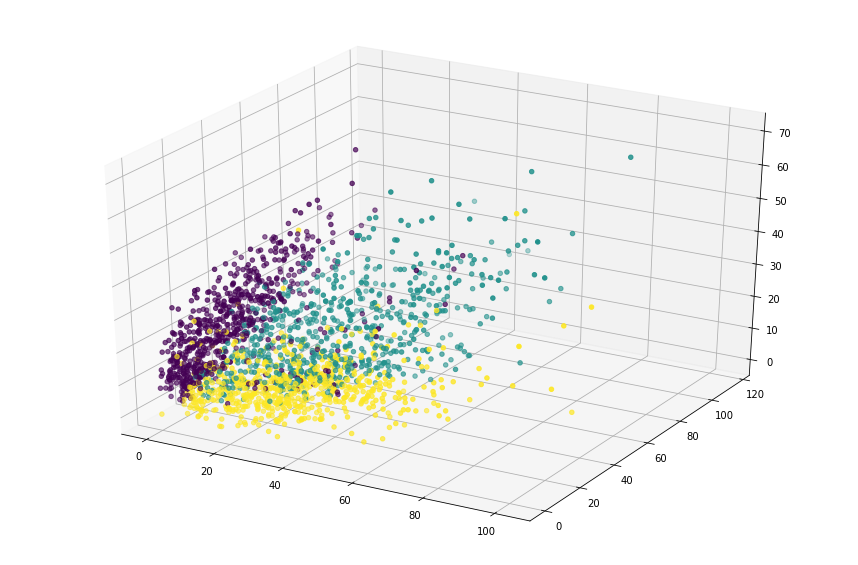

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=data_reduced.c1, ys=data_reduced.c2, zs=data_reduced.c3, c=data_reduced['class'], marker='o')
plt.show()